In [1]:
import sys
sys.path.append('../..')

import eeg_decoder 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd
import scipy.stats as sista
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pingouin

import matplotlib
plt.rcParams['svg.fonttype'] = 'none'
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"

np.random.seed(42)
%load_ext autoreload
%autoreload 2

/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
output_dir = Path('./output')
fig_dir = output_dir / 'figures'

behavior = None
experiment_name = 'data' 
data_dir = f'./data/'
exp = eeg_decoder.Experiment(experiment_name,data_dir,dev=False)
    
behavior = pd.DataFrame()
for isub in range(exp.nsub):
    # Load subject's behavior data
    temp = pd.DataFrame(exp.load_behavior(isub))[['Subject','SetSize','BlockFeature','ACC','RT']]
    temp['Subject'] = isub
    behavior = pd.concat([behavior,temp],axis=0)

behavior.tail()

,Subject,SetSize,BlockFeature,ACC,RT
1048,15,2,0,1,1666.115479
1049,15,2,0,1,612.309406
1050,15,2,0,1,540.392259
1051,15,0,0,1,275.781465
1052,15,0,0,1,279.534767


In [3]:
behavior = behavior.query('SetSize != 0')
total_means = behavior.groupby(['SetSize','BlockFeature'])['ACC'].mean().reset_index(drop=True)
subject_means = behavior.groupby(['Subject', 'SetSize','BlockFeature'])['ACC'].mean().reset_index()
subject_means['BlockFeature'] = subject_means['BlockFeature'].map({0:'Color',1:'Motion'})
total_means

0    0.989633
1    0.893935
2    0.978113
3    0.807265
Name: ACC, dtype: float64

In [4]:
subject_means.to_csv('output/subject_accs.csv',index=False)
subject_means

,Subject,SetSize,BlockFeature,ACC
0,0,1,Color,1.000000
1,0,1,Motion,0.938053
2,0,2,Color,0.981481
3,0,2,Motion,0.662037
4,1,1,Color,1.000000
...,...,...,...,...
59,14,2,Motion,0.839744
60,15,1,Color,0.987500
61,15,1,Motion,0.770213
62,15,2,Color,0.975709


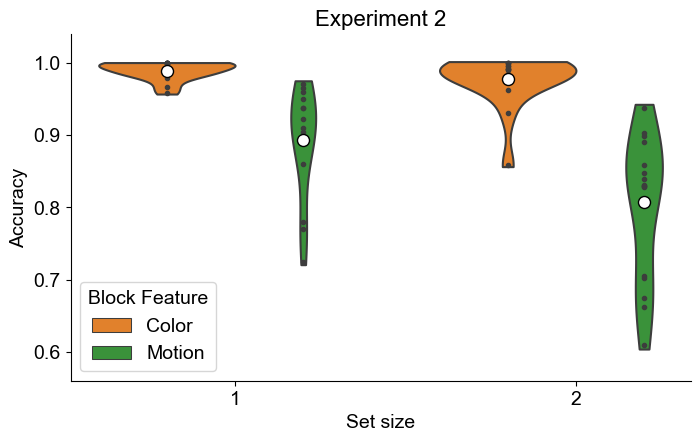

In [5]:
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8,4.5))
my_pal = {'Color': 'tab:orange', 'Motion': 'tab:green'}

# experiment 1
sns.violinplot(
    ax = ax,
    x = 'SetSize',
    y = 'ACC',
    hue = 'BlockFeature',
    data = subject_means,
    dodge=True,
    inner='points',
    palette=my_pal,
    cut=.1
)
ax = plt.gca()
# plot means
ax.scatter(
    x = [-.2,.2,.8,1.2],
    y = [total_means[0],total_means[1],total_means[2],total_means[3]],
    c = 'white', edgecolors='k',s=75)

# asethetics
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
ax.set_xlabel('Set size',fontsize=14)
ax.set_ylabel('Accuracy',fontsize=14)
ax.set_title('Experiment 2',fontsize=16)
plt.legend(loc='lower left',fontsize=14,title_fontsize=14)
leg = ax.get_legend()
leg.set_title(title='Block Feature')
plt.ylim([.56,1.04])
plt.savefig(f'{fig_dir}/cd_accuracy.png',dpi=500,bbox_inches='tight')
plt.savefig(f'{fig_dir}/cd_accuracy.svg',bbox_inches='tight')

plt.show()

# Accuracy ANOVA within each experiment

In [6]:
subject_means = subject_means.rename({'BlockFeature':'Feature'},axis=1)

In [7]:
from statsmodels.stats.anova import AnovaRM
aovrm = AnovaRM(subject_means, 'ACC', 'Subject', within=['Feature','SetSize'],aggregate_func='mean')
res = aovrm.fit()
print(res)

                    Anova
                F Value Num DF  Den DF Pr > F
---------------------------------------------
Feature         41.3537 1.0000 15.0000 0.0000
SetSize         30.6159 1.0000 15.0000 0.0001
Feature:SetSize 21.8808 1.0000 15.0000 0.0003



In [8]:
subject_means.groupby(['Feature'])['ACC'].mean()

Feature
Color     0.983273
Motion    0.847656
Name: ACC, dtype: float64

In [9]:
subject_means.groupby(['Feature'])['ACC'].std()

Feature
Color     0.027442
Motion    0.097189
Name: ACC, dtype: float64

## test of the interaction

In [10]:
ss2_color = subject_means.query('SetSize==2 & Feature=="Color"')
ss2_motion = subject_means.query('SetSize==2 & Feature=="Motion"')
ss1_color = subject_means.query('SetSize==1 & Feature=="Color"')
ss1_motion = subject_means.query('SetSize==1 & Feature=="Motion"')

# assert that the subjects are in the same order
assert all(ss2_color.Subject.values == ss2_motion.Subject.values)
assert all(ss2_motion.Subject.values == ss1_color.Subject.values)
assert all(ss1_color.Subject.values == ss1_motion.Subject.values)

# is the feature difference larger in set size 2 than in set size 1?
diffs = (ss2_color.ACC.values - ss2_motion.ACC.values) - (ss1_color.ACC.values - ss1_motion.ACC.values)

In [11]:
from pingouin import ttest
ttest(diffs, y=0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,4.677689,15,two-sided,0.000298,"[0.04, 0.11]",1.169422,109.496,0.991834
